In [2]:
import numpy as np
import pandas as pd

Preprocessing:
- removing all data whos feature vector is irregular (longer than the column of 44 or something)
- removed all commas in CSV so that it doesn't interfere with the read_csv
- drop features with missing values
- deleted non-movies
- threw out data with multiple parentheses appearences
- translate all titles to english
- removed year and other parentheses from title
- choosing to use snowball(Porter2) stemmer
- remove punctuation
- parsed titles and appended tfidf

Title Processing Steps:
- remove the year in title
- remove punctuation
- translate to english
- remove and added aposthrophes
- stem the title

Visualization?:
- distribution of languages for movies (maybe keep track of performance for certain language of movie titles)


# Loading  Data

In [24]:
from langdetect import detect
import time
from google.cloud import translate_v2 as translate
import nltk
import nltk.stem as stem
from nltk import word_tokenize as tokenize
import re
import string
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/Users/hamilton/Desktop/Stuff/GoogleAPIKey/MovieTranslation-f8371579c36e.json'

In [2]:
def load_data():
    client = translate.Client()
    stemmer = stem.snowball.EnglishStemmer()    
    table = str.maketrans('','',string.punctuation)
    data = pd.read_csv("./imdbmovies/imdb.csv")
    
    idxRemove = data[np.logical_not(np.isnan(data['Unnamed: 44']))].index
    dataCleaned = data.drop(idxRemove)
    idxNonMovie = dataCleaned[dataCleaned["type"] != 'video.movie'].index
    dataCleaned.drop(idxNonMovie, inplace=True)
    idxTwoParen = dataCleaned[dataCleaned["title"].str.contains("\(.*\(")].index
    dataCleaned.drop(idxTwoParen, inplace=True)

    dataCleaned.drop(columns=["Unnamed: 44", "Unnamed: 45", "Unnamed: 46", "Unnamed: 47"], inplace=True)
    dataCleaned.dropna(axis=0, inplace=True)
    dataCleaned.reset_index(inplace=True)
    dataCleaned.drop(columns=["index", "url", "tid", "fn", "wordsInTitle", "type"], inplace=True)
    dataCleaned.title = dataCleaned.title.apply(lambda title: re.sub(r'\(([ a-zA-Z]*)([0-9]{4})\)', r'\1', title))\
                                    .apply(lambda title: title.translate(table))\
                                    .apply(lambda title: client.translate(title)["translatedText"].replace("&#39;", ""))\
                                    .apply(lambda title: " ".join([stemmer.stem(word) for word in tokenize(title)]))
    
    X = dataCleaned.iloc[:, :11]
    y = dataCleaned.iloc[:, 11:]
    
    return X, y

In [13]:
start = time.time()
shortX, y = load_data()
print("Time to load data: {} seconds".format(time.time() - start))

Time to load data: 0.3057441711425781 seconds


In [5]:
y = pd.read_csv("../imdbmovies/labels.csv")
fullX = pd.read_csv("../imdbmovies/features_vectorized.csv")
shortX = pd.read_csv("../imdbmovies/features.csv")

In [7]:
print("Labels ", y.columns.to_list())
print("Features ", shortX.columns.to_list())

Labels  ['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'FilmNoir', 'GameShow', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'RealityTV', 'Romance', 'SciFi', 'Short', 'Sport', 'TalkShow', 'Thriller', 'War', 'Western']
Features  ['title', 'imdbRating', 'ratingCount', 'duration', 'year', 'nrOfWins', 'nrOfNominations', 'nrOfPhotos', 'nrOfNewsArticles', 'nrOfUserReviews', 'nrOfGenre']


# Text Vectorization

In [8]:
import sklearn.feature_extraction.text as extraction

Vectorizing Title

In [9]:
tfidfVector = extraction.TfidfVectorizer()
tfidf = tfidfVector.fit_transform(shortX.pop('title'))

Appending Vectorized words to X array

In [ ]:
for i, col in enumerate(tfidfVector.get_feature_names()):
    X[col] = pd.Series(pd.SparseArray(tfidf[:, i].toarray().ravel(), fill_value=0))

In [14]:
fullX = pd.read_csv("./imdbmovies/features_vectorized.csv")

Creating the Vectorized words

In [10]:
key = {v: k for k,v in tfidfVector.vocabulary_.items()}
words = pd.DataFrame(tfidf.todense())
words.rename(columns=key, inplace=True)
# words.to_csv("./imdbmovies/vectorization.csv"")

# PCA

In [11]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

Using TruncatedPCA because it works best on tfidf/sparse arrays

In [27]:
svd = TruncatedSVD(words.shape[1] - 1).fit(words)

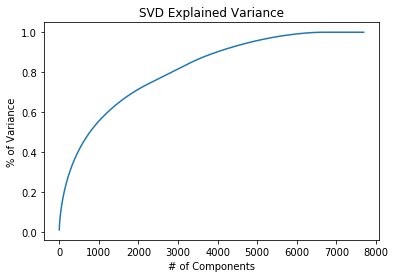

In [31]:
variances = np.cumsum(svd.explained_variance_ratio_)
plt.plot(variances)
plt.xlabel("# of Components")
plt.ylabel("% of Variance")
plt.title("SVD Explained Variance")
plt.show()

<Figure size 432x288 with 0 Axes>

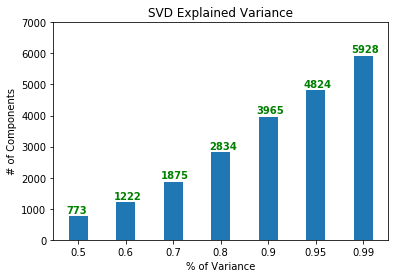

In [99]:
varSums = [.5, .6, .7, .8, .9, .95, .99]
numComps = [variances[variances < s].size for s in varSums]
plt.clf()
_, ax = plt.subplots()
for i, v in enumerate(numComps):
    ax.text(i - .25, v + 100, str(v), color='green', fontweight='bold')
y_pos = np.arange(len(varSums))
plt.bar(y_pos, numComps, align='center', width=.4)
plt.xticks(y_pos, varSums)
plt.ylim(0, 7000)
plt.title("SVD Explained Variance")
plt.xlabel("% of Variance")
plt.ylabel("# of Components")
plt.show()

In [14]:
words50 = TruncatedSVD(773).fit_transform(words)
words70 = TruncatedSVD(1875).fit_transform(words)
words80 = TruncatedSVD(2834).fit_transform(words)
words90 = TruncatedSVD(3965).fit_transform(words)

In [15]:
# np.savetxt("../imdbmovies/vectorization50.csv", words50, delimiter=",")
# np.savetxt("./imdbmovies/vectorization70.csv", words70, delimiter=',')
# np.savetxt("./imdbmovies/vectorization80.csv", words80, delimiter=',')
# np.savetxt("./imdbmovies/vectorization90.csv", words90, delimiter=',')